# 1.Library

In [14]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow
from kerastuner.tuners import RandomSearch
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV


# 2.Read data from csv file

In [15]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean

In [16]:
df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)
features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'
df['AWS2'] = df['AWS']

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour']     = df['datetime'].dt.hour
df['doy']      = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2*np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2*np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2*np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2*np.pi * df['doy']  / 365)


dftrain = df[df['datetime'] <= pd.Timestamp('2020-10-15 23:00:00')].reset_index(drop=True)
dftest = df[df['datetime'] >= pd.Timestamp('2020-10-16 00:00:00')].reset_index(drop=True)
print(len(df))
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.transform(dftest[features])


dftest.head()

600608


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,V250,V850,AWS2,year,hour,doy,hour_sin,hour_cos,doy_sin,doy_cos
0,0,104,2020-10-16 00:00:00,1.4,-0.778566,1.151669,-0.157100,-0.000008,0.676296,0.691164,...,0.308077,-0.461880,2.247177,2020,0,290,-0.005889,1.428931,-1.120592,1.234326
1,0,104,2020-10-16 01:00:00,1.4,-0.773494,1.151669,-0.184226,-0.000014,0.676296,0.533721,...,0.211001,-0.586356,2.247177,2020,1,290,0.362716,1.381061,-1.120592,1.234326
2,0,104,2020-10-16 02:00:00,0.0,-0.764092,1.151669,-0.253074,-0.000025,0.676296,0.406218,...,0.199645,-0.850797,-0.189937,2020,2,290,0.706200,1.240713,-1.120592,1.234326
3,0,104,2020-10-16 03:00:00,0.0,-0.752339,1.151669,-0.340492,-0.000034,0.676296,0.339875,...,0.288680,-1.145032,-0.189937,2020,3,290,1.001157,1.017450,-1.120592,1.234326
4,0,104,2020-10-16 04:00:00,0.0,-0.755308,1.151669,-0.280227,-0.000047,0.676296,0.275151,...,0.363835,-1.287848,-0.189937,2020,4,290,1.227486,0.726489,-1.120592,1.234326


In [17]:
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.transform(dftest[features])

In [18]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    time = data['datetime'].tolist()
    for i in range(window_size, len(data)-horizon+1):
        check = False
        for j in range(i-window_size+1, i+horizon):
            if (time[j] - time[j-1]).total_seconds() != 3600:
                check = True
                break
        if check:
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


In [20]:
window_size = 1
horizon     = 6

X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (351315, 1, 14) (351315, 6)
Test shapes: (74038, 1, 14) (74038, 6)


In [ ]:
def model_eval(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    mae = mean_absolute_error(y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r2 = r2_score(y_test,y_pred)
    print("R-squared:", r2)
    corr, p = stats.pearsonr(y_test.reshape(-1), y_pred.reshape(-1))
    print("Pearson Correlation Coefficient:", corr)

# 3.Models

## 3.1 Lasso

In [ ]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

In [ ]:
print(X_train.shape, y_train.shape)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.3521919661651019
Mean Absolute Error: 0.2470592598074645
R-squared: 0.21552512420504136
Pearson Correlation Coefficient: 0.5728019110736913


## 3.2 ridge

In [ ]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

In [ ]:
print(X_train.shape, y_train.shape)
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.33941421390670223
Mean Absolute Error: 0.2594186303563895
R-squared: 0.2438770822820068
Pearson Correlation Coefficient: 0.5711419173050725


## 3.3 random forest

In [ ]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

### 3.3.1 Default random forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.30050459319966344
Mean Absolute Error: 0.23392541950262194
R-squared: 0.3297776865099215
Pearson Correlation Coefficient: 0.5790717930250696


### 3.3.2 Random forest with random search cv

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
param_dist = {
    'max_depth': [7, 8, 9, 10, 11],
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5], 
    'bootstrap': [True],
}

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [ ]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 4.0min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 3.9min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.9min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 3.7min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 3.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=125; total t

In [ ]:
print(best_params)

{'n_estimators': 175, 'min_samples_leaf': 5, 'max_depth': 11, 'bootstrap': True}


In [ ]:
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.3489252997749654
Mean Absolute Error: 0.21917975182455415
R-squared: 0.22368996555245882
Pearson Correlation Coefficient: 0.517322715996719


## 3.4.XGboost

### 3.4.1 Default XGboost

In [ ]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


In [40]:
xgbr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth = 7, random_state=42)

In [41]:
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [42]:
y_pred = xgbr_model.predict(X_test.reshape(-1,10))
load_model = xgbr_model
model_eval(y_test, y_pred)

Mean Squared Error: 0.3803239352569092
Mean Absolute Error: 0.28902213995028453
R-squared: 0.1508133557478034
Pearson Correlation Coefficient: 0.464220366670041


### 3.4.2 XGBoost with RandomSearchCV

In [12]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
param_dist = {
    'learning_rate': [0.01,0.03,0.05,0.07],
    'max_depth': [14, 16, 18, 20, 22, 24, 26, 28, 30],
    'n_estimators': [100, 125, 150, 175, 200],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [ 0.6,0.7, 0.8,0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
}

random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [13]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  24.1s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  23.8s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  19.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  36.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  36.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  26.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_ra

In [14]:
y_pred = random_search.predict(X_test.reshape(-1,10))
model_eval(y_test, y_pred)
print("Best parameters:", best_params)

Mean Squared Error: 0.3976790486550255
Mean Absolute Error: 0.24751842756907208
R-squared: 0.1179669523412074
Pearson Correlation Coefficient: 0.3958460784760168
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 16, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.9}


## 3.5 Lstm

In [8]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)

Reloading Tuner from rs_lstm\lstm_rs\tuner0.json
Best hyperparameters found:
  units1   = 128
  units2   = 64
  dropout1 = 0.30
  dropout2 = 0.20
  lr       = 0.0001
Epoch 1/100


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8783/8783 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.1428 - mae: 0.1236 - val_loss: 0.2416 - val_mae: 0.1561
Epoch 2/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.1415 - mae: 0.1113 - val_loss: 0.2446 - val_mae: 0.1592
Epoch 3/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1365 - mae: 0.1081 - val_loss: 0.2612 - val_mae: 0.1730
Epoch 4/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1357 - mae: 0.1082 - val_loss: 0.2605 - val_mae: 0.1684
Epoch 5/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1322 - mae: 0.1061 - val_loss: 0.2702 - val_mae: 0.1714
Epoch 6/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.1309 - mae: 0.1066 - val_loss: 0.2772 - val_mae: 0.1716
Epoch 7/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.1315 - mae: 0.1066 - val_loss: 0.2952 - val_mae: 0.1813
Epoch 8/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 0.1311 - mae: 0.1052 - val_loss: 0.3202 - val_mae: 0.1893
Epoch 9/100
8783/8783 ━━━━━━━━━━━━━━

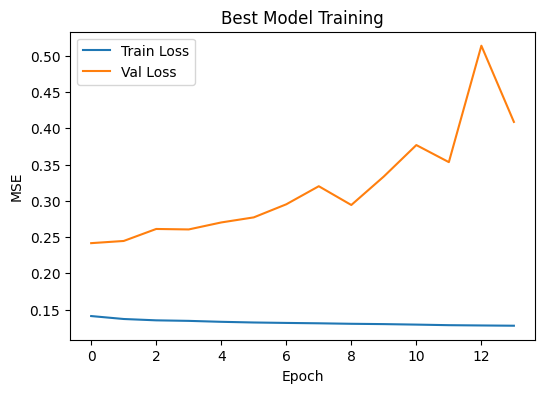

In [12]:
n_features = len(features)

def build_stacked_lstm(window_size, n_features, horizon,
                       units1, units2, dropout1, dropout2, lr):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    # Dense output
    model.add(Dense(horizon, activation='linear'))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


def build_model_hp(hp):
    return build_stacked_lstm(
        window_size=window_size,
        n_features=n_features,
        horizon=horizon,
        units1=hp.Choice('units1', [64, 128, 256]),
        units2=hp.Choice('units2', [32, 64, 128]),
        dropout1=hp.Float('dropout1', 0.1, 0.5, step=0.1),
        dropout2=hp.Float('dropout2', 0.1, 0.5, step=0.1),
        lr=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    )


tuner = RandomSearch(
    build_model_hp,
    objective='val_loss',    
    max_trials=5,             
    executions_per_trial=1,
    directory='rs_lstm',
    project_name='lstm_rs'
)


tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
lstm_model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(f"  units1   = {best_hp.get('units1')}")
print(f"  units2   = {best_hp.get('units2')}")
print(f"  dropout1 = {best_hp.get('dropout1'):.2f}")
print(f"  dropout2 = {best_hp.get('dropout2'):.2f}")
print(f"  lr       = {best_hp.get('lr')}")

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
    ],
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training')
plt.legend()
plt.show()


In [11]:
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
y_pred = lstm_model.predict(X_test)
model_eval(y_test, y_pred)

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mean Squared Error: 0.2978291119236452
Mean Absolute Error: 0.22993908241274
R-squared: 0.3360494652259016
Pearson Correlation Coefficient: 0.5839190010991426


# Weather forcast result

In [33]:
best_model = tensorflow.keras.models.load_model('best_model_2.h5', custom_objects={'mse': tensorflow.keras.losses.MeanSquaredError})

In [38]:
y_pred = best_model.predict(X_test)
model_eval(y_test, y_pred)

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean Squared Error: 0.302810418194619
Mean Absolute Error: 0.2333444442081023
R-squared: 0.32502810844826674
Pearson Correlation Coefficient: 0.5758373680006177


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

C:\Users\Dell\AppData\Local\Temp\ipykernel_15048\2953863488.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


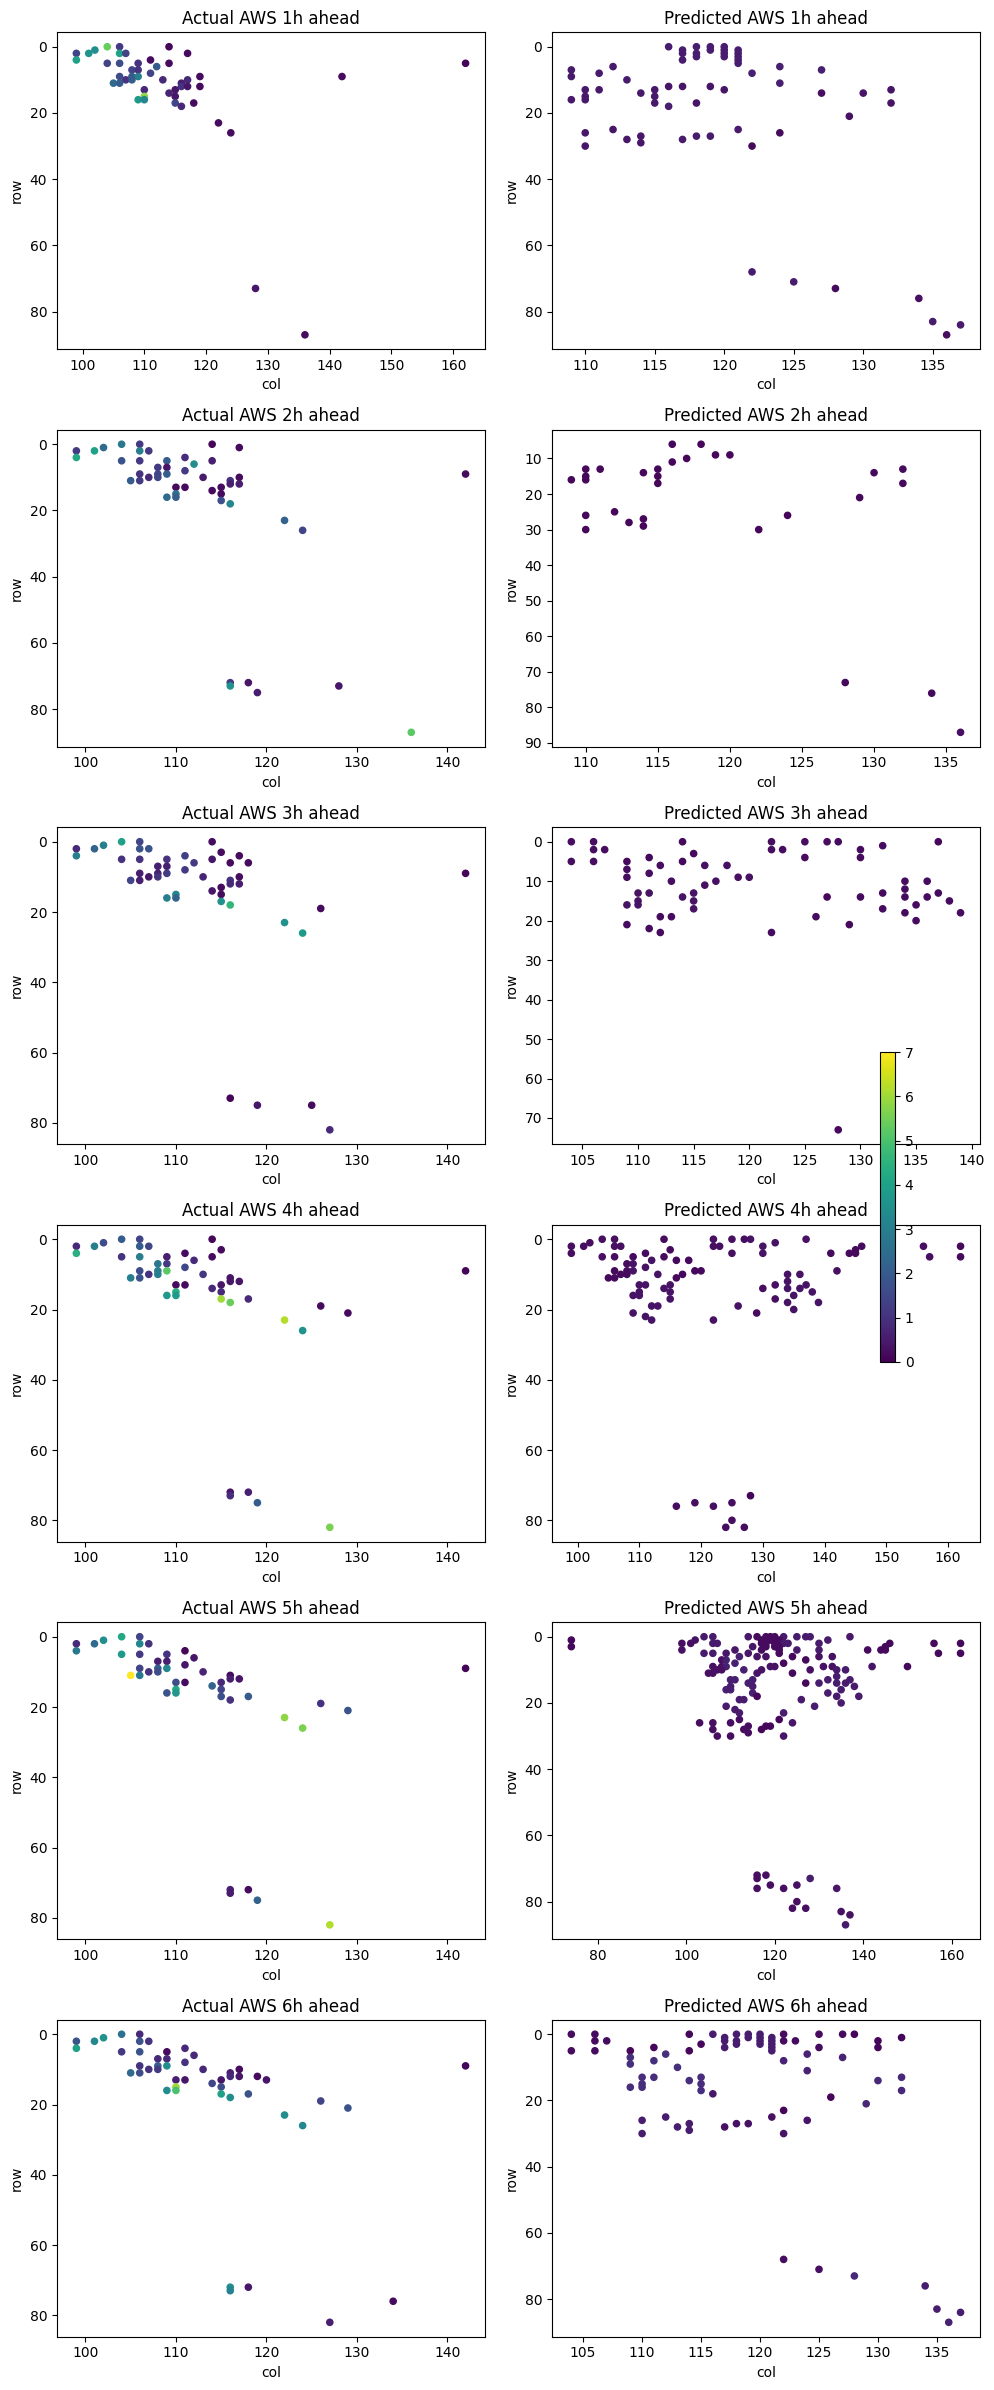

In [13]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-10-29 9:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = best_model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

pred_map[pred_map <= 0.1 ] = np.nan
act_map[act_map == 0 ] = np.nan

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
